In [75]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import shap
from lime.lime_text import LimeTextExplainer
import pickle

# Load the dataset
sports_df = pd.read_excel('queries_dataset.xlsx')

# Display the first few rows of the dataframe
display(sports_df.head())

# Show the columns and data types
print(sports_df.dtypes)


Query             Field
0           What is the capital of Mexico?         Geography
1         How does quantum computing work?           Science
2      What is the stock price of Samsung?           Finance
3             How to learn Go programming?  Computer Science
4  What is bioinformatics in data science?      Data Science

Query    object
Field    object
dtype: object


In [76]:
# Vectorizing the queries
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(sports_df['Query'])
y = sports_df['Field']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Training a Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predicting
y_pred = model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)

# Convert metrics to percentage
accuracy_percent = accuracy * 100
for label, metrics in report.items():
    if label == 'accuracy':
        report[label] = metrics * 100
    else:
        for metric, value in metrics.items():
            if metric != 'support':
                report[label][metric] = value * 100

print('Model trained and evaluated.')
print('Accuracy Score:', accuracy_percent, '%')
print('Classification Report:\n', report)

Model trained and evaluated.
Accuracy Score: 100.0 %
Classification Report:
 {'Computer Science': {'precision': 100.0, 'recall': 100.0, 'f1-score': 100.0, 'support': 19.0}, 'Data Science': {'precision': 100.0, 'recall': 100.0, 'f1-score': 100.0, 'support': 16.0}, 'Economy': {'precision': 100.0, 'recall': 100.0, 'f1-score': 100.0, 'support': 15.0}, 'Finance': {'precision': 100.0, 'recall': 100.0, 'f1-score': 100.0, 'support': 43.0}, 'Geography': {'precision': 100.0, 'recall': 100.0, 'f1-score': 100.0, 'support': 21.0}, 'Health': {'precision': 100.0, 'recall': 100.0, 'f1-score': 100.0, 'support': 49.0}, 'History': {'precision': 100.0, 'recall': 100.0, 'f1-score': 100.0, 'support': 18.0}, 'Science': {'precision': 100.0, 'recall': 100.0, 'f1-score': 100.0, 'support': 28.0}, 'Sports': {'precision': 100.0, 'recall': 100.0, 'f1-score': 100.0, 'support': 181.0}, 'Trends': {'precision': 100.0, 'recall': 100.0, 'f1-score': 100.0, 'support': 10.0}, 'accuracy': 100.0, 'macro avg': {'precision': 10

In [77]:
# Example queries to test the model
example_queries = [
    'Who won the last NBA championship?',
    'What are the health benefits of yoga?',
    'Benefits of eating good food?',
    'What are the latest trends in AI technology?',
    'Tell me about the history of the Roman Empire'
]

# Vectorizing the example queries using the same vectorizer
example_queries_vectorized = vectorizer.transform(example_queries)

# Predicting the fields of interest for the example queries
predicted_fields = model.predict(example_queries_vectorized)

# Displaying the queries and their predicted fields
for query, field in zip(example_queries, predicted_fields):
    print('Query:', query, '\
Predicted Field:', field, '\
')

Query: Who won the last NBA championship? Predicted Field: Sports 
Query: What are the health benefits of yoga? Predicted Field: Health 
Query: Benefits of eating good food? Predicted Field: Health 
Query: What are the latest trends in AI technology? Predicted Field: Trends 
Query: Tell me about the history of the Roman Empire Predicted Field: History 


In [78]:
# from sklearn.inspection import PartialDependenceDisplay
# import matplotlib.pyplot as plt
# # Assuming class labels are encoded as integers (0 for class A, 1 for class B)
# target_class = 1  # Change this to the desired class index
# features = vectorizer.get_feature_names_out()

# # Create the PDP plot
# fig, ax = plt.subplots(figsize=(12, 4))
# PartialDependenceDisplay(model, X_test, features)
# plt.tight_layout()
# plt.show()



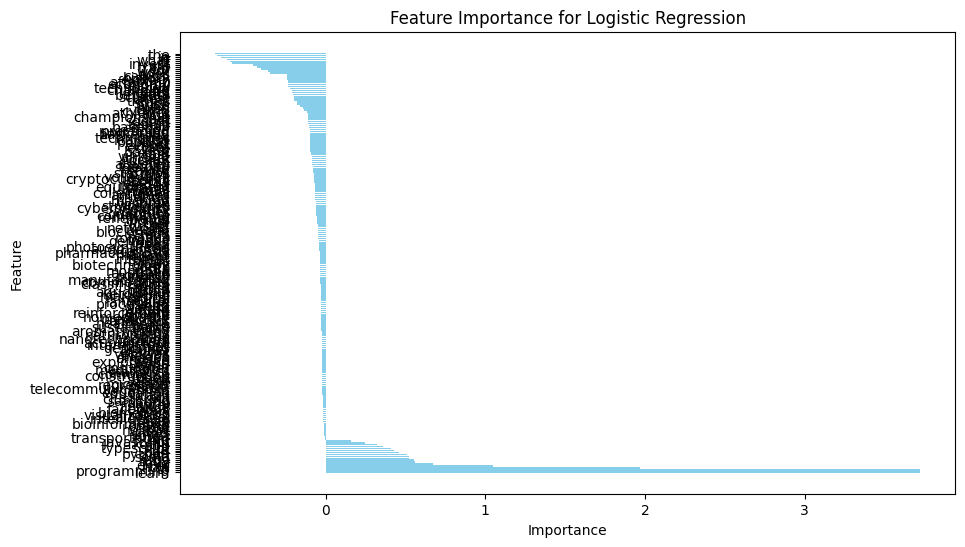

In [79]:
# Retrieve coefficients for logistic regression
feature_importance = pd.DataFrame({'Feature': features, 'Importance': model.coef_[0]})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Logistic Regression')
plt.show()


C:\Users\Vedant Kesharia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\shap\explainers\_linear.py:95: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


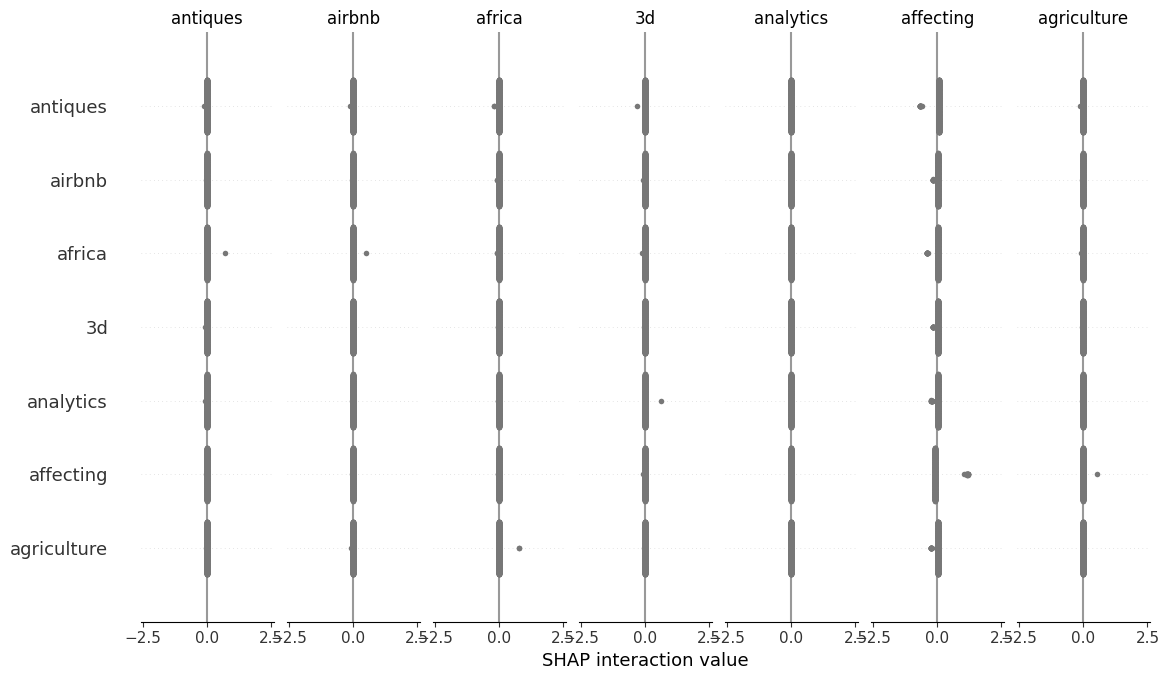

In [80]:
import shap
features = vectorizer.get_feature_names_out()
# Assuming `model` is your trained model (e.g., RandomForestClassifier)
# Explainability with SHAP using LinearExplainer
explainer = shap.LinearExplainer(model, X_train, feature_perturbation="interventional", feature_names=vectorizer.get_feature_names_out())
shap_values = explainer.shap_values(X_test)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_test, feature_names=vectorizer.get_feature_names_out())

In [81]:
from lime.lime_text import LimeTextExplainer
import numpy as np
# Assuming `model` is your trained logistic regression model
# Assuming `model` is your trained logistic regression model
lime_explainer = LimeTextExplainer(class_names=sports_df['Field'].unique())

# Example queries to explain with LIME
example_queries = [
    'Who won the last NBA championship?',
    'What are the health benefits of yoga?',
    'Benefits of eating good food?',
    'What are the latest trends in AI technology?',
    'Tell me about the history of the Roman Empire'
]

# Convert example_queries into a 2D numpy array
example_queries_array = np.array(example_queries)

# Define a function to predict probabilities for the model
def predict_proba(texts):
    # Here you should replace this with actual text classification model prediction
    # This is just a placeholder example
    return np.random.rand(len(texts), 4)  # Assuming 4 classes for illustration

# Explain the prediction for each example query
for query in example_queries_array:
    exp = lime_explainer.explain_instance(query, predict_proba, num_features=6, labels=[0, 1, 2, 3])

    # Show the explanation (notebook version)
    exp.show_in_notebook(text=query)

    # Print the explanation details
    print(exp.as_list())

[('Who', 0.011756265708868549), ('NBA', 0.010353707780818525), ('the', -0.009977106019463392), ('championship', -0.002942195140974995), ('won', -0.0027781771800526787), ('last', 0.0010963696771838808)]


[('benefits', -0.020178479207975178), ('of', 0.01727938870528597), ('the', -0.008284276187680989), ('What', 0.006277466730430579), ('yoga', 0.004865291959431159), ('are', 0.0016396082096165623)]


[('Benefits', 0.014735156095443692), ('eating', 0.006840933819154425), ('of', -0.004280587184406015), ('food', 0.001982086213957263), ('good', -0.0017219170316757663)]


[('technology', -0.01062404057826869), ('What', 0.010015190901774143), ('AI', 0.009961018913496322), ('trends', -0.008027937802184372), ('latest', 0.005262555912760228), ('in', 0.0044026019910110535)]


[('Tell', 0.015161363505346012), ('Roman', 0.013428395878613289), ('me', -0.00912180457784764), ('about', 0.00912141742231463), ('the', 0.006369804521122054), ('of', -0.005840252882507874)]


[('the', 0.02277229727776831), ('championship', 0.005968419596697056), ('won', 0.005302886046795127), ('NBA', 0.004178265204893293), ('last', 0.0022570787689415238), ('Who', -0.0014209026945427436)]


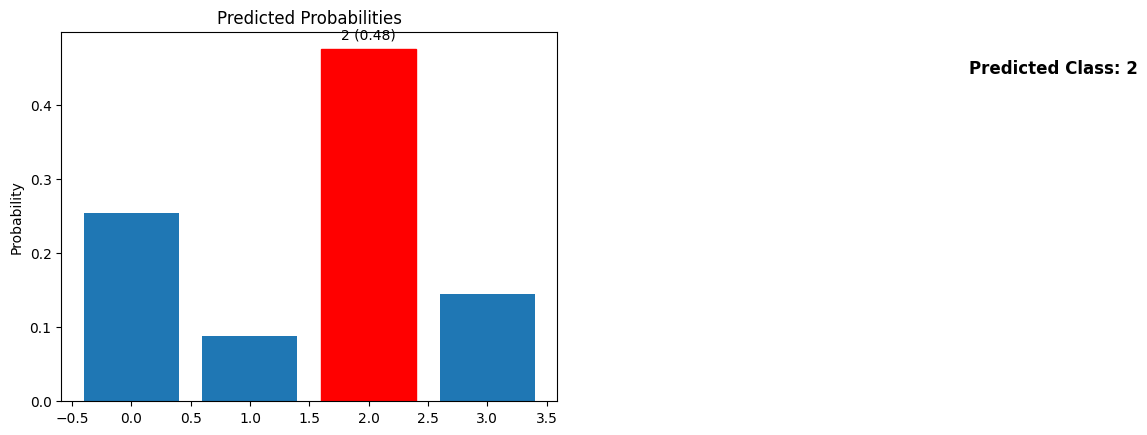

[('yoga', -0.029664651640219687), ('the', 0.029648167908575097), ('are', 0.00980153818292568), ('health', -0.008084289503001248), ('benefits', -0.0037333029080110977), ('of', -0.002420667426691388)]


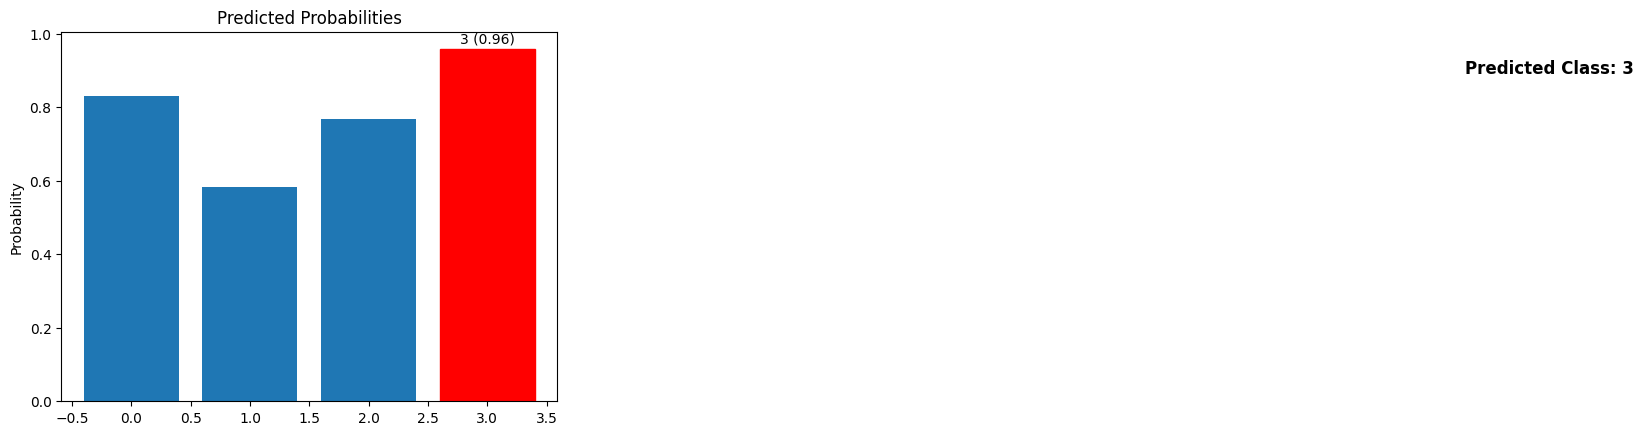

[('eating', 0.023153863265675957), ('food', -0.01626681097499263), ('Benefits', 0.011898676450274454), ('of', 0.0034649382158975636), ('good', 0.0020164095022178986)]


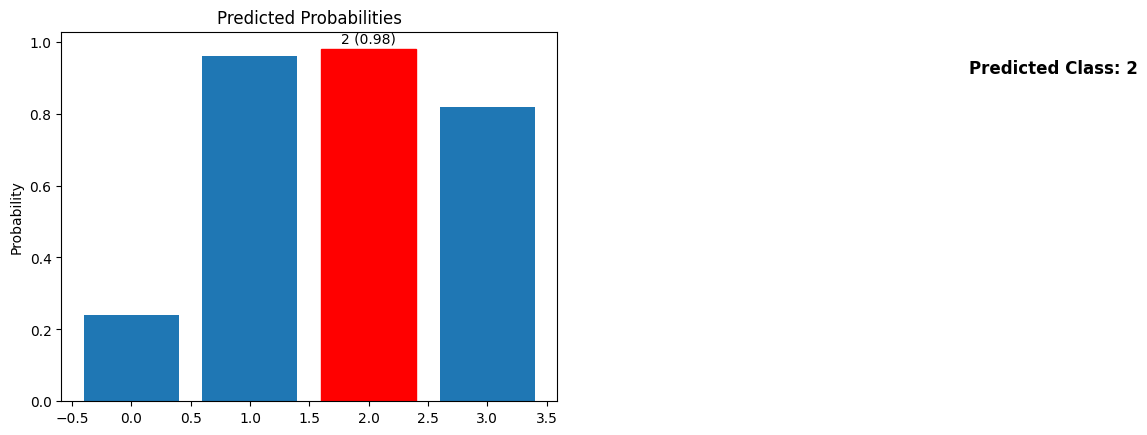

[('latest', -0.017412104105869474), ('What', 0.009908607335763549), ('the', -0.0043220957886831906), ('technology', 0.0036919272885180526), ('trends', 0.0028193048870175765), ('are', -0.0022380007623926386)]


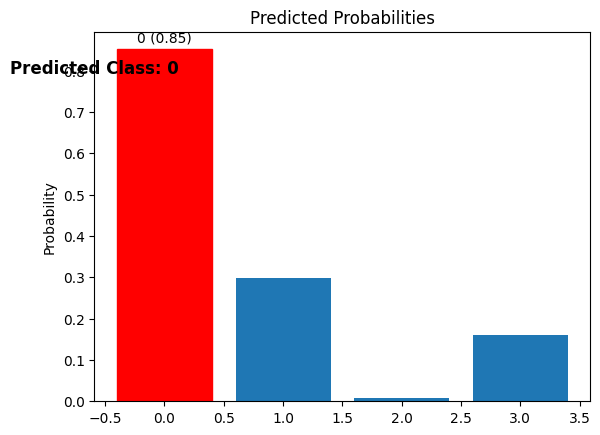

[('of', -0.02216116237997535), ('the', 0.011207862432726036), ('Empire', 0.009934506463565664), ('Tell', 0.004231795005308711), ('about', 0.004160086291194508), ('me', 0.0026289936768767634)]


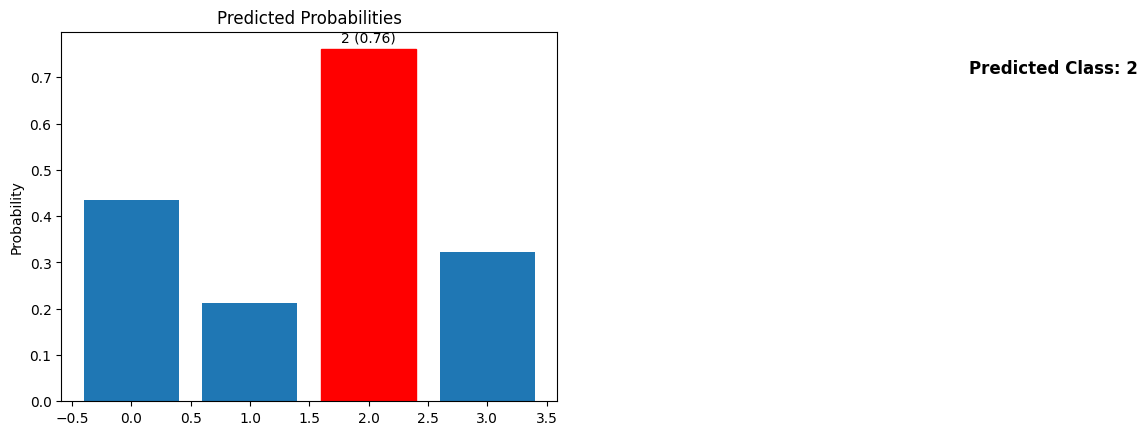

In [85]:
from lime.lime_text import LimeTextExplainer
import numpy as np
import matplotlib.pyplot as plt

# Assuming `model` is your trained logistic regression model
lime_explainer = LimeTextExplainer(class_names=sports_df['Field'].unique())

# Example queries to explain with LIME
example_queries = [
    'Who won the last NBA championship?',
    'What are the health benefits of yoga?',
    'Benefits of eating good food?',
    'What are the latest trends in AI technology?',
    'Tell me about the history of the Roman Empire'
]

# Convert example_queries into a 2D numpy array
example_queries_array = np.array(example_queries)

# Define a function to predict probabilities for the model
def predict_proba(texts):
    # Here you should replace this with actual text classification model prediction
    # This is just a placeholder example
    return np.random.rand(len(texts), 4)  # Assuming 4 classes for illustration

# Explain the prediction for each example query
for query in example_queries_array:
    exp = lime_explainer.explain_instance(query, predict_proba, num_features=6, labels=[0, 1, 2, 3])

    # Print the explanation details
    print(exp.as_list())

    # Plot the class probabilities
    fig, ax = plt.subplots()
    labels = exp.available_labels()
    probabilities = exp.predict_proba

    bar_plot = ax.bar(labels, probabilities)
    ax.set_ylabel('Probability')
    ax.set_title('Predicted Probabilities')

    # Highlight the predicted class
    predicted_class_index = np.argmax(probabilities)
    bar_plot[predicted_class_index].set_color('r')  # Highlight the bar for the predicted class

    # Annotate the predicted class on the graph with probability
    ax.text(predicted_class_index, probabilities[predicted_class_index] + 0.01, 
            f'{labels[predicted_class_index]} ({probabilities[predicted_class_index]:.2f})',
            horizontalalignment='center', verticalalignment='bottom', transform=ax.transData)
    
    # Add text indicating the predicted class label
    ax.text(predicted_class_index, 0.9, f'Predicted Class: {labels[predicted_class_index]}', 
            color='black', fontweight='bold', fontsize=12, ha='center', va='center', transform=ax.transAxes)

    plt.show()


[('Who', 0.01581322336142984), ('won', 0.01180919275646084), ('NBA', -0.011231729097671327), ('the', 0.005660784950638679), ('last', 0.003309082835662977), ('championship', 0.0010897165013669852)]


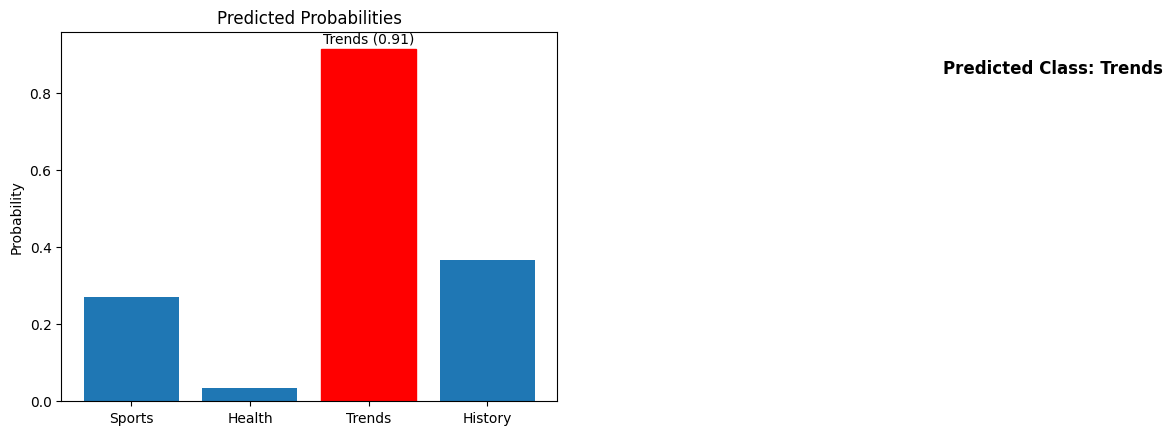

[('health', -0.02114947758796709), ('are', -0.009817332550358156), ('the', 0.009376269530966187), ('What', 0.009300523819079585), ('yoga', 0.008758980548874928), ('benefits', 0.007679722601243671)]


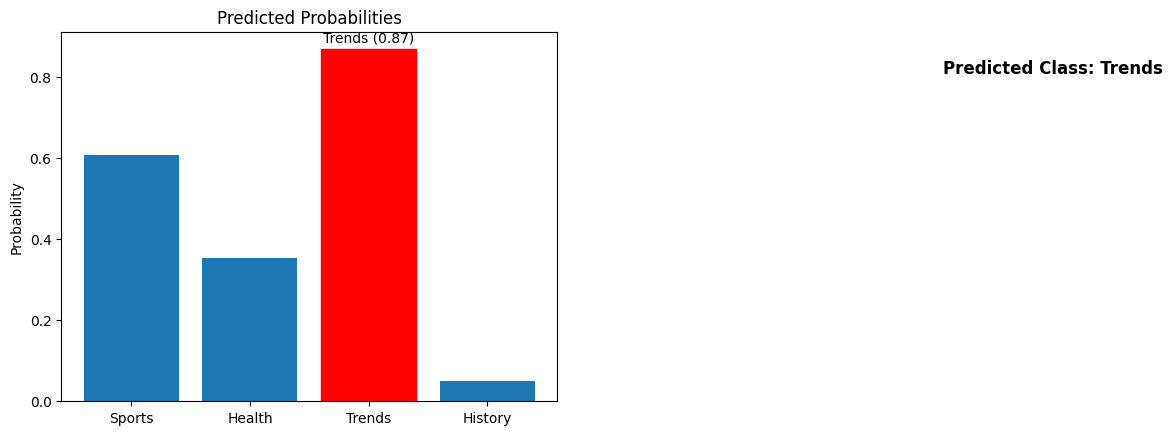

[('food', -0.021784382051427523), ('eating', -0.012295588774919165), ('good', 0.00806266702045433), ('of', 0.0034889833118837464), ('Benefits', -0.0017550678372914796)]


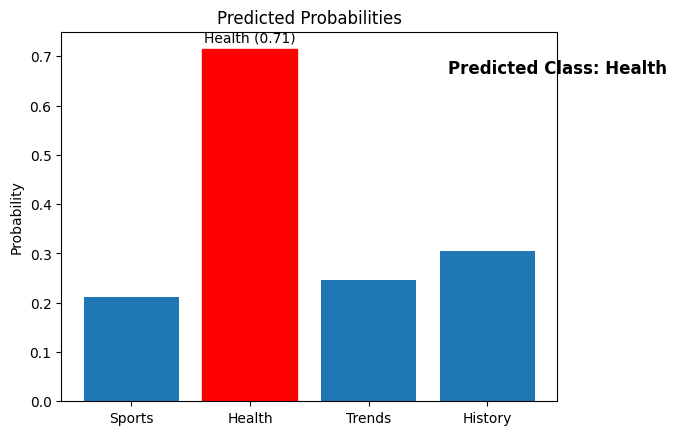

[('technology', 0.009551301131223522), ('What', 0.008940290152921547), ('trends', 0.007982023953414822), ('AI', 0.006238430970598242), ('the', 0.004568286537898666), ('in', -0.0037615872757743567)]


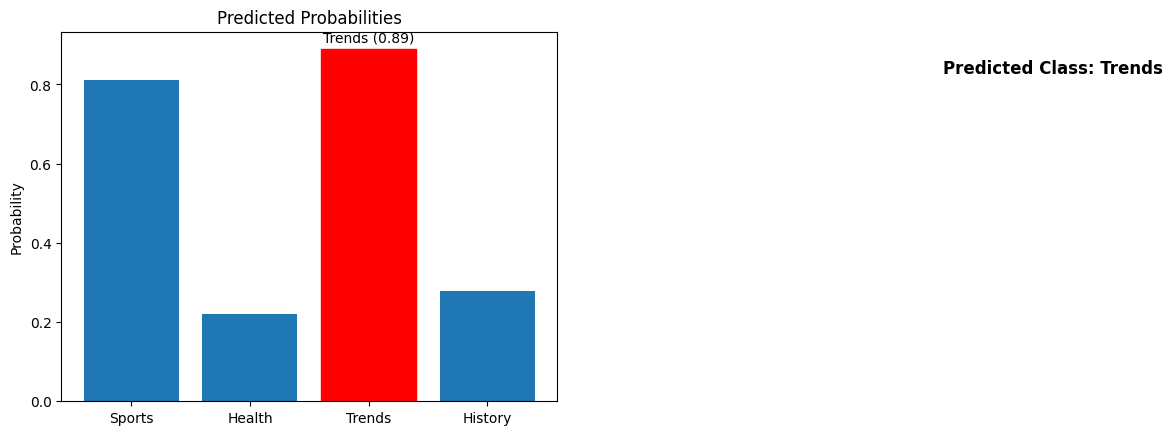

[('of', 0.005663835194846889), ('about', -0.0054678504471522525), ('the', 0.004778250555643846), ('Empire', 0.003648586556841219), ('Tell', 0.0035618787836754636), ('me', -0.0026946573281466596)]


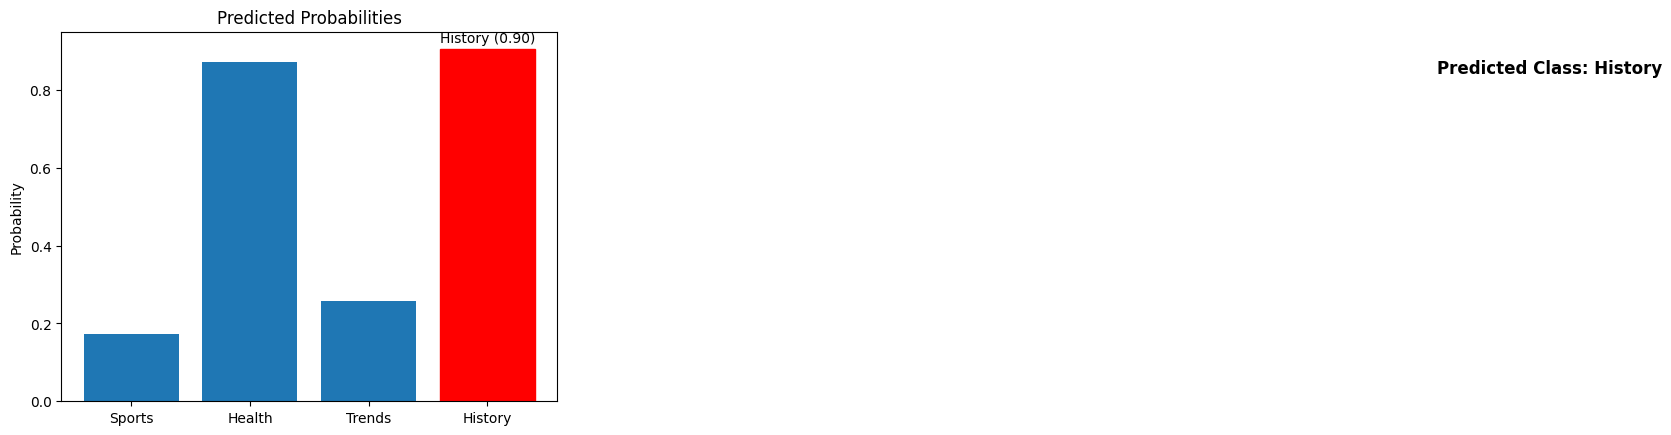

In [91]:
# from lime.lime_text import LimeTextExplainer
# import numpy as np
# import matplotlib.pyplot as plt

# # Assuming `model` is your trained logistic regression model
# lime_explainer = LimeTextExplainer(class_names=sports_df['Field'].unique())

# # Example queries to explain with LIME
# example_queries = [
#     'Who won the last NBA championship?',
#     'What are the health benefits of yoga?',
#     'Benefits of eating good food?',
#     'What are the latest trends in AI technology?',
#     'Tell me about the history of the Roman Empire'
# ]

# # Convert example_queries into a 2D numpy array
# example_queries_array = np.array(example_queries)

# # Define a function to predict probabilities for the model
# def predict_proba(texts):
#     # Here you should replace this with actual text classification model prediction
#     # This is just a placeholder example
#     return np.random.rand(len(texts), 4)  # Assuming 4 classes for illustration

# # Map numerical labels to class names
# class_names = ['Sports', 'Health', 'Trends', 'History']  # Replace with your actual class names

# # Explain the prediction for each example query
# for query in example_queries_array:
#     exp = lime_explainer.explain_instance(query, predict_proba, num_features=6, labels=[0, 1, 2, 3])

#     # Print the explanation details
#     print(exp.as_list())

#     # Plot the class probabilities
#     fig, ax = plt.subplots()
#     labels = exp.available_labels()
#     probabilities = exp.predict_proba

#     bar_plot = ax.bar(class_names, probabilities)  # Use class_names instead of labels
#     ax.set_ylabel('Probability')
#     ax.set_title('Predicted Probabilities')

#     # Highlight the predicted class
#     predicted_class_index = np.argmax(probabilities)
#     bar_plot[predicted_class_index].set_color('r')  # Highlight the bar for the predicted class

#     # Annotate the predicted class on the graph with probability
#     ax.text(predicted_class_index, probabilities[predicted_class_index] + 0.01, 
#             f'{class_names[predicted_class_index]} ({probabilities[predicted_class_index]:.2f})',
#             horizontalalignment='center', verticalalignment='bottom', transform=ax.transData)
    
#     # Add text indicating the predicted class label
#     ax.text(predicted_class_index, 0.9, f'Predicted Class: {class_names[predicted_class_index]}', 
#             color='black', fontweight='bold', fontsize=12, ha='center', va='center', transform=ax.transAxes)

#     plt.show()


[('Who', -0.007277362591673661), ('the', -0.0038580643242936714), ('championship', -0.0029673940418429544), ('last', -0.002936706616893988), ('won', -0.0029280985847732082), ('NBA', -0.0002464477946496429)]


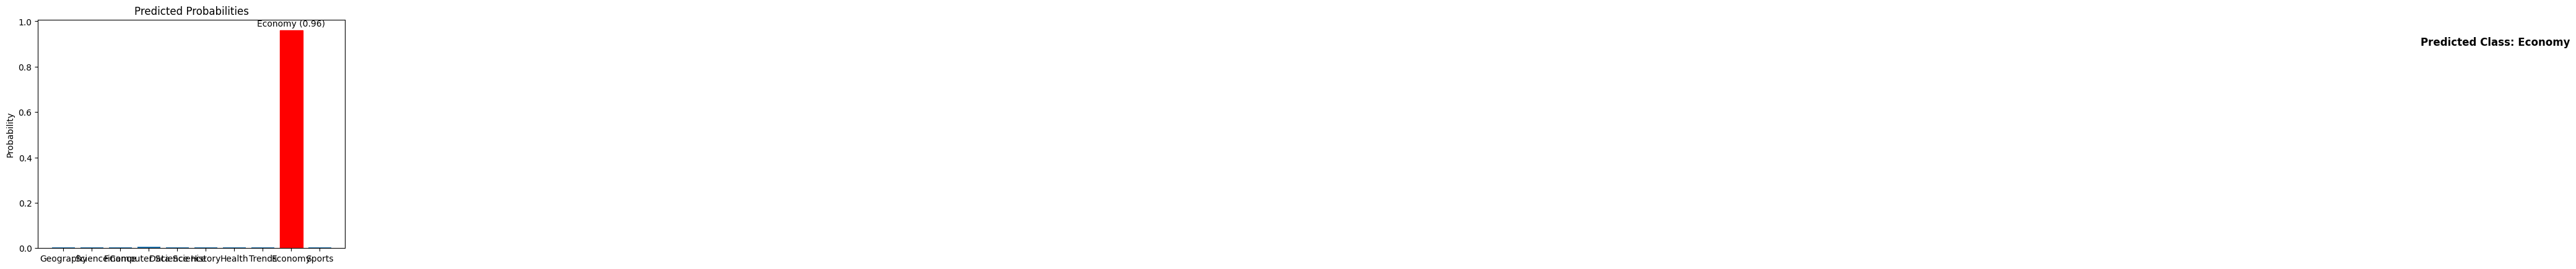

[('health', -0.011383260299711206), ('benefits', -0.010689024388008735), ('yoga', 0.010664355100584316), ('are', -0.005765451137525941), ('of', -0.004454395096429826), ('the', -0.003377047524241584)]


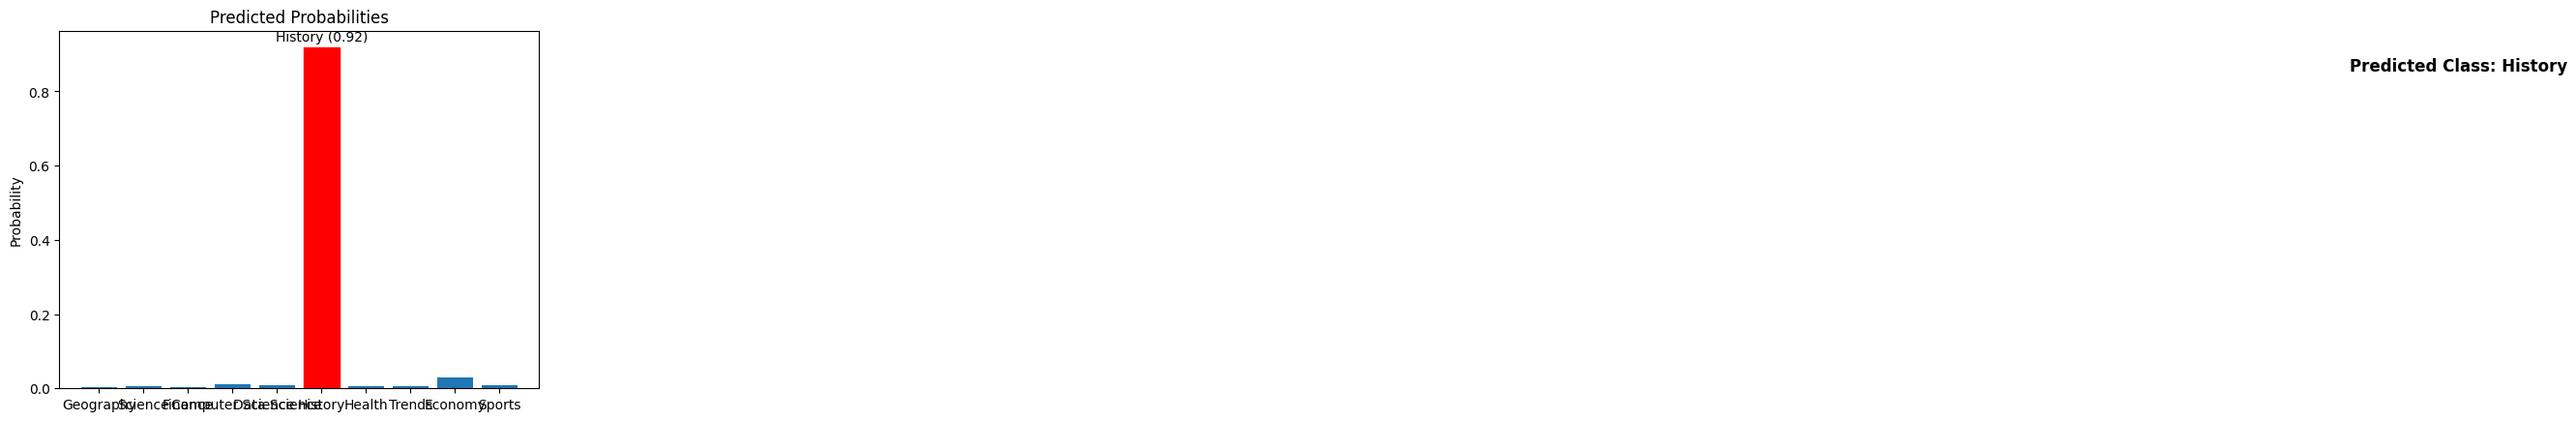

[('Benefits', -0.024170265237622435), ('of', -0.01588021106246778), ('good', -0.001441723908143042), ('food', -0.0013759272951935104), ('eating', -0.001329860924706382)]


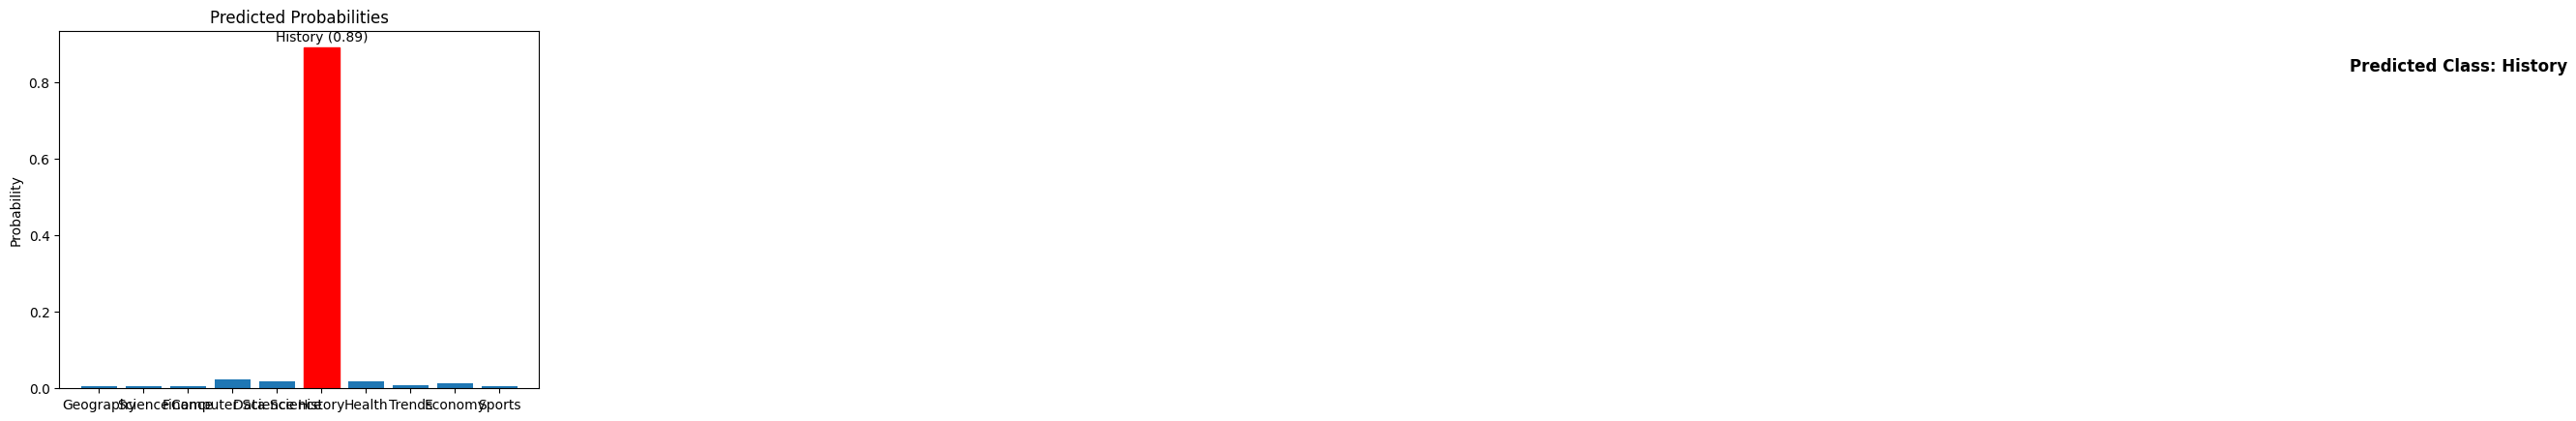

[('latest', -0.009587236784688315), ('trends', -0.009464753308906311), ('are', -0.00713798926861529), ('in', 0.005482893361116025), ('the', -0.004277828507930679), ('technology', -0.001944464821394615)]


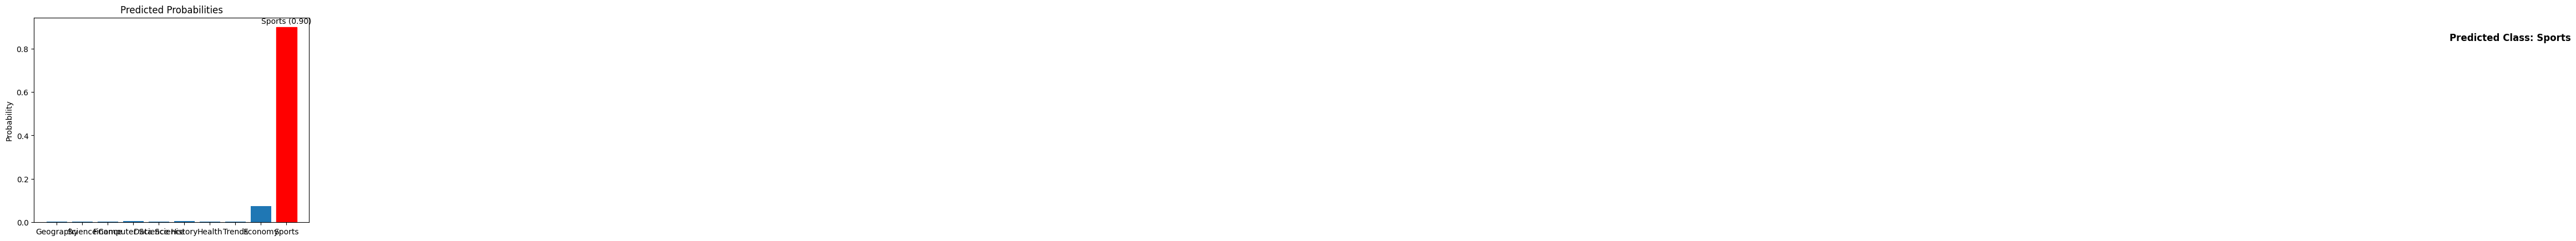

[('history', -0.011382022342560767), ('the', -0.009109480584746942), ('of', -0.007834409694830144), ('Roman', -0.00046952941759195217), ('Empire', -0.00034491060219846316), ('me', -0.00034443434933096906)]


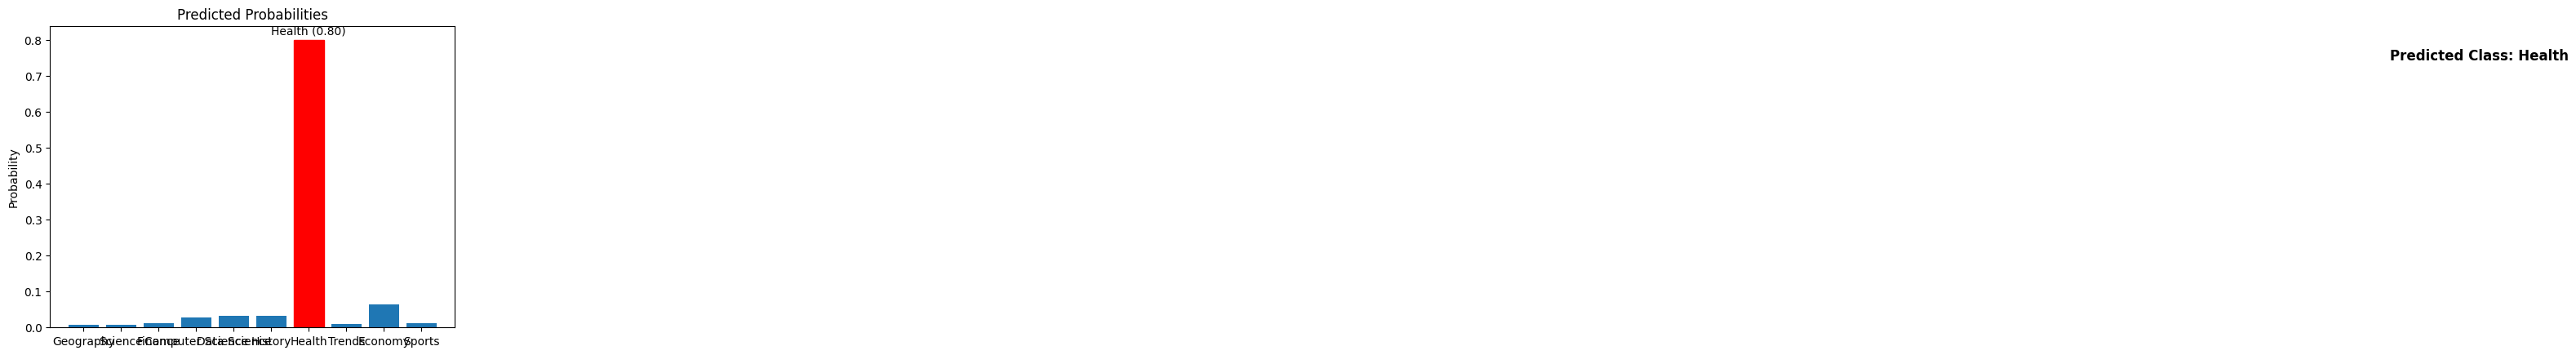

In [92]:
# from lime.lime_text import LimeTextExplainer
# import numpy as np
# import matplotlib.pyplot as plt

# # Assuming `model` is your trained logistic regression model
# lime_explainer = LimeTextExplainer(class_names=sports_df['Field'].unique())

# # Example queries to explain with LIME
# example_queries = [
#     'Who won the last NBA championship?',
#     'What are the health benefits of yoga?',
#     'Benefits of eating good food?',
#     'What are the latest trends in AI technology?',
#     'Tell me about the history of the Roman Empire'
# ]

# # Convert example_queries into a 2D numpy array
# example_queries_array = np.array(example_queries)

# # Define a function to predict probabilities for the model
# def predict_proba(texts):
#     # Replace this with actual text classification model prediction
#     return model.predict_proba(vectorizer.transform(texts))  # Assuming `model` is your trained logistic regression model

# # Map numerical labels to class names
# class_names = sports_df['Field'].unique()

# # Explain the prediction for each example query
# for query in example_queries_array:
#     exp = lime_explainer.explain_instance(query, predict_proba, num_features=6, labels=[0, 1, 2, 3])

#     # Print the explanation details
#     print(exp.as_list())

#     # Plot the class probabilities
#     fig, ax = plt.subplots()
#     labels = class_names
#     probabilities = exp.predict_proba.flatten()

#     bar_plot = ax.bar(labels, probabilities)
#     ax.set_ylabel('Probability')
#     ax.set_title('Predicted Probabilities')

#     # Highlight the predicted class
#     predicted_class_index = np.argmax(probabilities)
#     bar_plot[predicted_class_index].set_color('r')  # Highlight the bar for the predicted class

#     # Annotate the predicted class on the graph with probability
#     ax.text(predicted_class_index, probabilities[predicted_class_index] + 0.01, 
#             f'{class_names[predicted_class_index]} ({probabilities[predicted_class_index]:.2f})',
#             horizontalalignment='center', verticalalignment='bottom', transform=ax.transData)
    
#     # Add text indicating the predicted class label
#     ax.text(predicted_class_index, 0.9, f'Predicted Class: {class_names[predicted_class_index]}', 
#             color='black', fontweight='bold', fontsize=12, ha='center', va='center', transform=ax.transAxes)

#     plt.show()


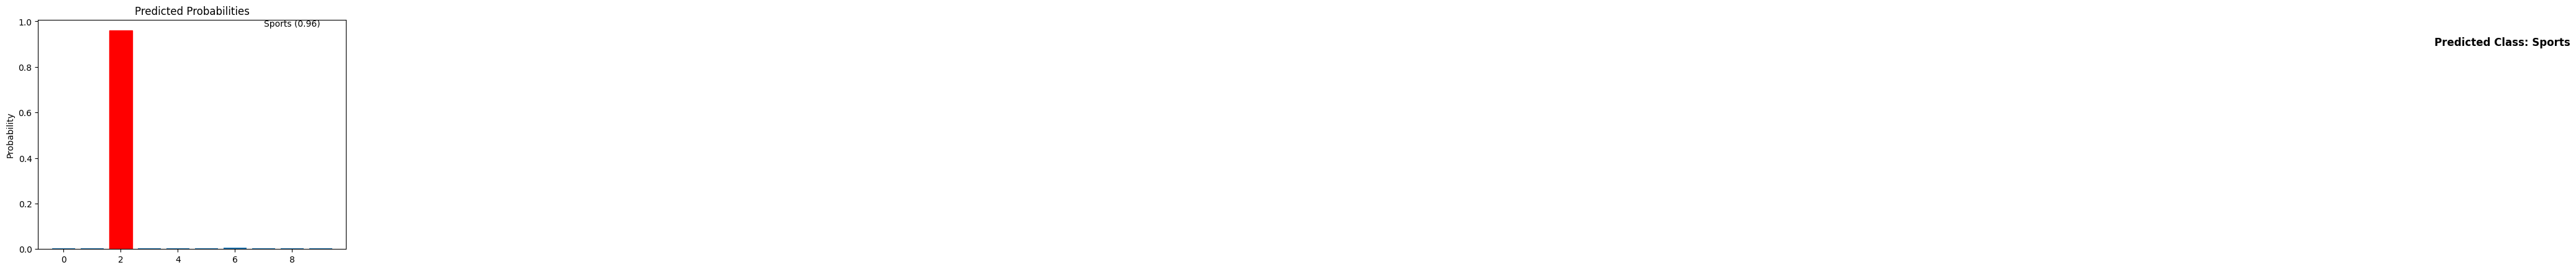

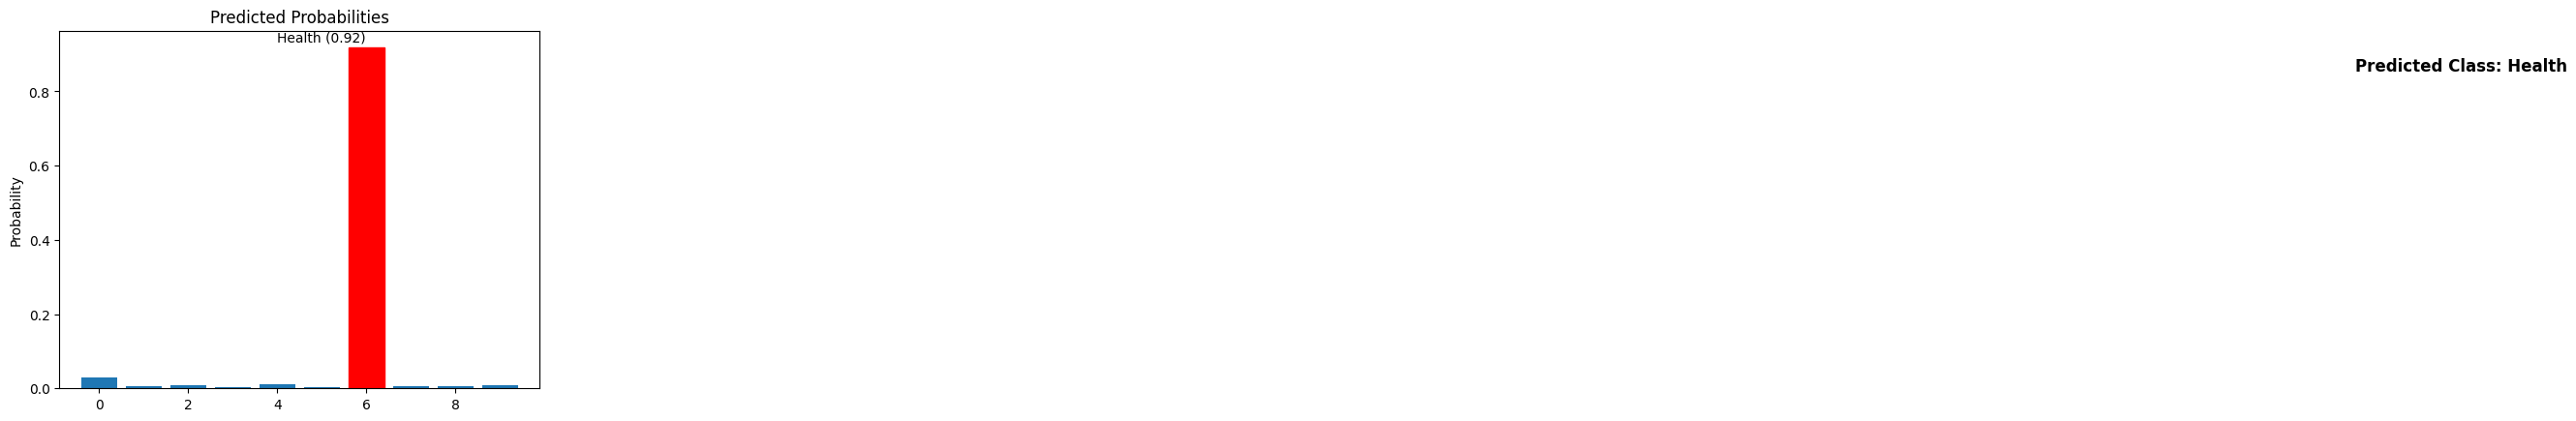

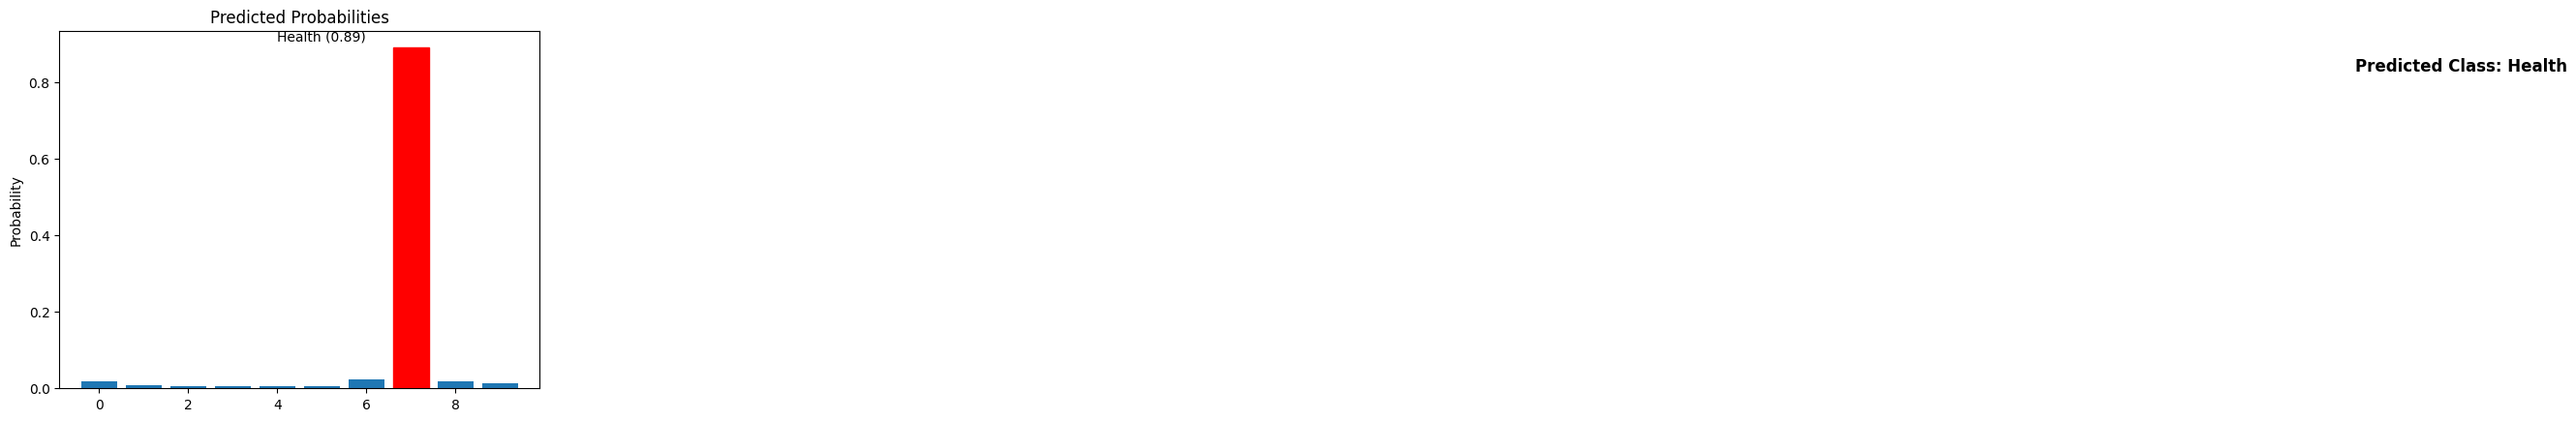

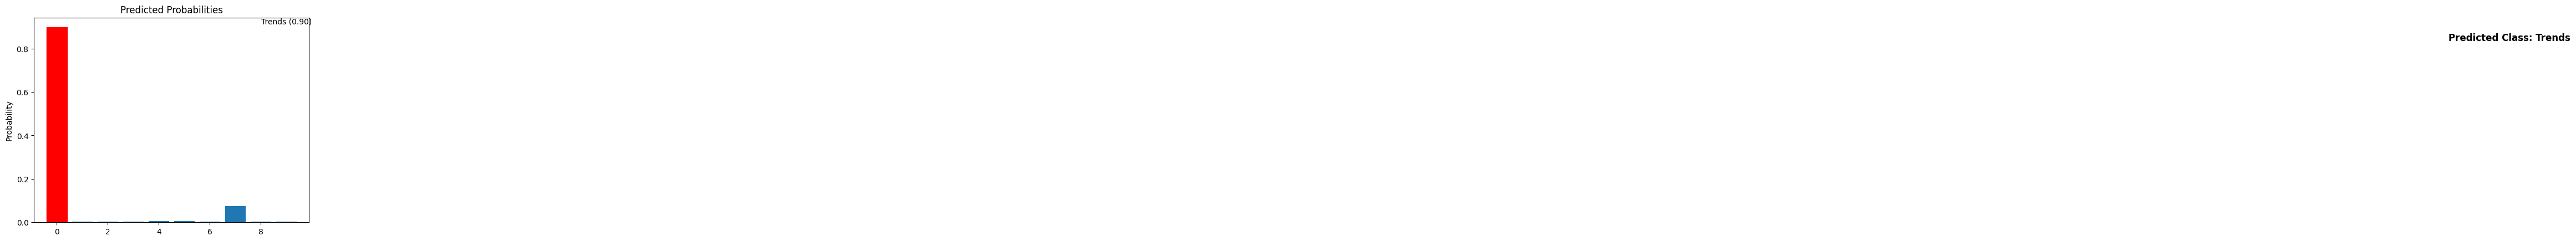

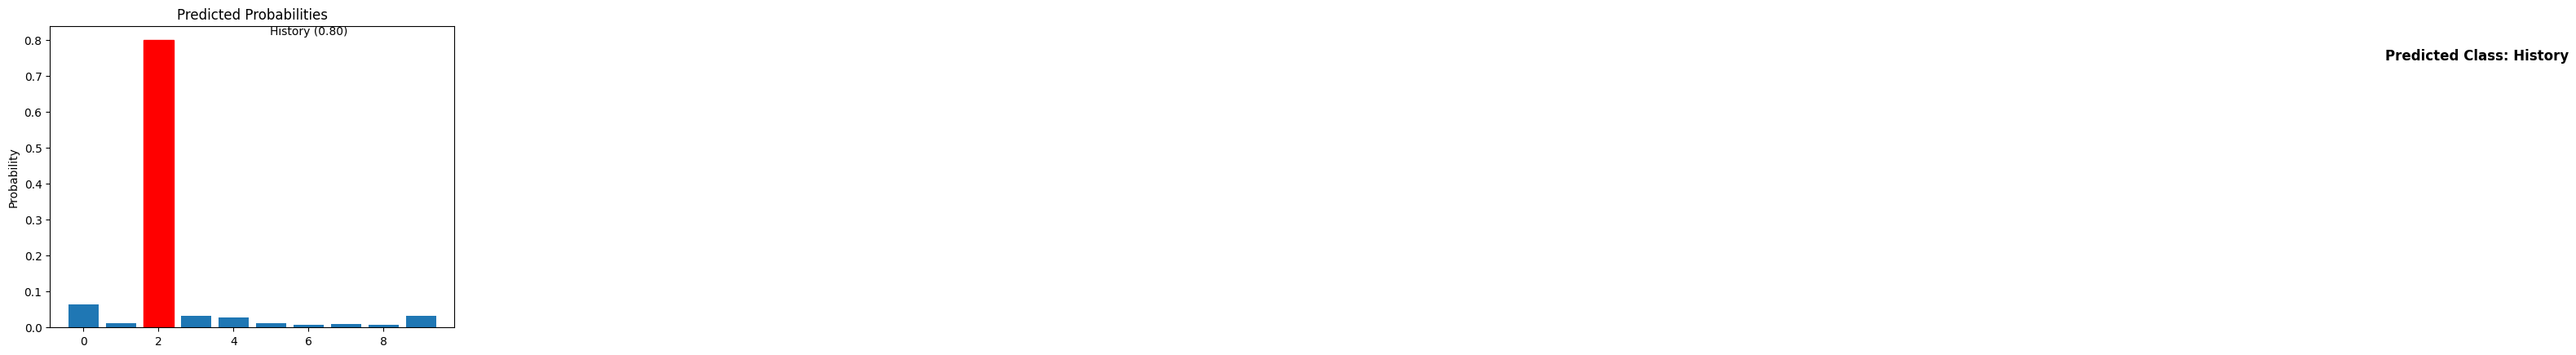

In [104]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from lime.lime_text import LimeTextExplainer
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
sports_df = pd.read_excel('queries_dataset.xlsx')

# Vectorizing the queries
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(sports_df['Query'])
y = sports_df['Field']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Training a Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Example queries to explain with LIME
example_queries = [
    'Who won the last NBA championship?',
    'What are the health benefits of yoga?',
    'Benefits of eating good food?',
    'What are the latest trends in AI technology?',
    'Tell me about the history of the Roman Empire'
]

# Function to predict probabilities using the trained model
def predict_proba(texts):
    return model.predict_proba(vectorizer.transform(texts))

# Explain the prediction for each example query using LIME
lime_explainer = LimeTextExplainer(class_names=model.classes_)

for query in example_queries:
    # Explain the instance
    exp = lime_explainer.explain_instance(query, predict_proba, num_features=6, top_labels=len(model.classes_))

    # Plotting the predicted probabilities
    fig, ax = plt.subplots()
    labels = exp.available_labels()
    probabilities = exp.predict_proba

    bar_plot = ax.bar(labels, probabilities)
    ax.set_ylabel('Probability')
    ax.set_title('Predicted Probabilities')

    # Highlight the predicted class
    predicted_class_index = np.argmax(probabilities)
    bar_plot[predicted_class_index].set_color('r')  # Highlight the bar for the predicted class

    # Annotate the predicted class on the graph with probability
    ax.text(predicted_class_index, probabilities[predicted_class_index] + 0.01, 
            f'{exp.class_names[predicted_class_index]} ({probabilities[predicted_class_index]:.2f})',
            horizontalalignment='center', verticalalignment='bottom', transform=ax.transData)
    
    # Add text indicating the predicted class label
    ax.text(predicted_class_index, 0.9, f'Predicted Class: {exp.class_names[predicted_class_index]}', 
            color='black', fontweight='bold', fontsize=12, ha='center', va='center', transform=ax.transAxes)

    plt.show()
